## Camera Position 2

In [1]:
def camera_position_2_convertion(x):
    
    #camera on the left hand side
    
    if x > 565:
        Yb = 0.36
        Xb = 613
        Ya = 0.55
        Xa = 565

    else:
        Yb = 0.55
        Xb = 565
        Ya = 1.01
        Xa = 344

    y = x* ((Yb-Ya)/(Xb-Xa)) + (((Ya*Xb)-(Yb*Xa))/(Xb-Xa))

    return y

camera_position_2_convertion(613)

0.3599999999999999

## Camera position 1

In [2]:

def camera_position_1_convertion(x):

    #camera on the right hand side
    if x < 290:
        Yb = 0.52
        Ya = 0.34
        Xa = 194
        Xb = 290
    else:
        Yb = 0.93
        Xb = 465
        Ya = 0.52
        Xa = 290

    y= x* ((Yb-Ya)/(Xb-Xa)) + (((Ya*Xb)-(Yb*Xa))/(Xb-Xa))
    return 3.14-y

camera_position_1_convertion(x = 400)

2.362285714285714

## Importing

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In [4]:
position_1 = pd.read_csv('person_tracking_position_1.csv')
position_2 = pd.read_csv('person_tracking_position_2.csv')

In [5]:
position_1 = position_1.drop(['Unnamed: 0'], axis =1)
position_2 = position_2.drop(['Unnamed: 0'], axis =1)

## cleaning position 1 data

#### Due to object tracking model uncertainty, the same person can be represented by different object_id, therefore we can have 2 onbject_id representing the same person at one frame. We need to have a dataset with only one object_id and one value x and y for each frame

In [6]:
g = position_1.groupby('frame_number')

frame_list = []
object_id_list = []
x_cor_list = []
y_cor_list = []
for g_id,g_df in g:
    frame_list.append(g_id)
    object_id_list.append(0)
    if len(g_df)>1:

        x_cor_list.append(g_df['x-coordinate'].iloc[-1])
        y_cor_list.append(g_df['y-coordinate'].iloc[-1])
        
    else:
        x_cor_list.append(g_df['x-coordinate'].values[0])
        y_cor_list.append(g_df['y-coordinate'].values[0])      

In [7]:
position_1 = pd.DataFrame()
position_1['object_id'] = object_id_list
position_1['frame_list'] = frame_list
position_1['x-coordinate'] = x_cor_list
position_1['y-coordinate'] = y_cor_list

In [8]:
position_1.head()

,object_id,frame_list,x-coordinate,y-coordinate
0,0,3,401,366
1,0,4,398,355
2,0,5,412,390
3,0,6,412,390
4,0,7,408,391


In [9]:
position_2.head()

,object_id,frame_number,x-coordinate,y-coordinate
0,0,1,613,381
1,0,2,613,381
2,0,3,613,382
3,0,4,612,382
4,0,5,612,384


#### check if there are overlapping frames

In [10]:
[print('overlapping') for i in np.unique(position_2['frame_number'], return_counts=True)[1] if i>1]

[]

## plot x,y

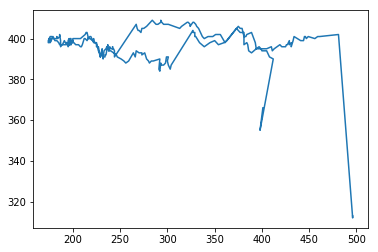

In [11]:
plt.plot(position_1['x-coordinate'], position_1['y-coordinate'])

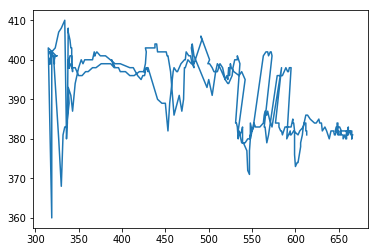

In [12]:
plt.plot(position_2['x-coordinate'], position_2['y-coordinate'])

In [11]:
len(position_1), len(position_2) giuseppe

(443, 439)

In [15]:
# delete frame 1 and 2 for data in position 2

position_2 = position_2.drop(position_2.index[[0,1]]).copy()
position_2 = position_2.reindex()

## Calculate angle

In [17]:
angles_position_1 = [camera_position_1_convertion(x) for x in position_1['x-coordinate']]
angles_position_2 = [camera_position_2_convertion(x) for x in position_2['x-coordinate']]

In [18]:
position_1['angle'] = angles_position_1
position_2['angle'] = angles_position_2

In [19]:
angles_position_2[0], angles_position_1[0]

(0.3599999999999999, 2.3599428571428573)

In [20]:
def radian_to_degree(x):
    return (x * 180)/3.14

def degree_to_radian(x):
    return (x * 3.14)/180

radian_to_degree(angles_position_2[0])
radian_to_degree(angles_position_1[0])

135.28334849863512

In [21]:
len(position_1), len(position_2)

(443, 437)

#### select only 1 frame every 15. The camera returned 30 frames each seconds. Therefore the distance in time between frames (taking one frame every 15) will be 0.5 seconds

In [22]:
z_1 = []
for i in range(16,len(position_1),15):
    z_1.append(position_1['angle'][i-15:i].mean())
len(z_1)

29

In [23]:
z_1 = z_1[:29]
len(z_1)

29

In [24]:
z_2 = []
for i in range(16,len(position_2),15):
    z_2.append(position_2['angle'][i-15:i].mean())
len(z_2)

29

In [25]:
z_2[6]

0.8799788838612365

## Uncented Kalman filters

In [26]:
import math
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn

In [27]:
def bearing(sensor, target_pos):
    '''given the sensor position and the target position calculate the angle.
    m = (y2-y1)/(x2 - x1) than teta = arctan(m)'''
    
    return math.atan2(target_pos[1] - sensor[1], 
                      target_pos[0] - sensor[0])

In [28]:
def measurement(A_pos, B_pos, pos):
    '''given the positions of the two sensors, and the expected position of the target, 
    this function return the angle of the target respect to the two sensor.
    A_pos is the sensor at the left position, B_pos is the sensor at the right position.
    The angles are calculated in radian and the origin of the angle is the axes x.'''
    
    angle_a = bearing(A_pos, pos)
    angle_b = bearing(B_pos, pos)
    return [angle_a, angle_b]

In [59]:
def fx_VOR(x, dt, u):
    '''this function predict the next position of the target, given the actual position and the u'''

    current_x = x[0] 
    current_y = x[2]
    
    next_position = estimate_next_position([current_x, current_y], u)

    x[1] = abs(next_position[0] - current_x) / 100 / dt #transform cm to m
    
    x[3] = abs(next_position[1] - current_y) / 100 / dt 
    
    
    x[0] = next_position[0]
    x[2] = next_position[1]
    return x

In [60]:
sa_pos = [-323, 0]
sb_pos = [350, 0]

def hx_VOR(x):
    
    '''after predict the position, hx_VOR return the angle in respect of the sensors'''
    # measurement to A
    pos = (x[0], x[2])
    #print('pos: '+str(pos))
    #print(measurement(sa_pos, sb_pos, pos))
    #print('measurement: ' + str(measurement(sa_pos, sb_pos, pos)))
    return measurement(sa_pos, sb_pos, pos)

In [61]:
def intercept_between_two_line(s2, s1):
    
    '''given the position of the sensor and the angles calculated previously.
    This function create to virtual stright line and calculate and return the point of intercept'''
    
    #s1 is the position on the right
    #s2 is the position on the left
    
    #z1 is the position on the right
    #z2 is the position on the left
    
    
    #print('s1: {} s2: {}'.format(s1,s2))
    m1 = np.tan(degree_to_radian(radian_to_degree(s1)))
    c1 = sb_pos[1] - sb_pos[0] * m1 
    
    m2 = np.tan(s2)
    c2 = sa_pos[1] - sa_pos[0] * m2 
        
    x = (c2 - c1)/(m1 - m2)
    y = (x * m1) + c1
    
    #print('x: {} , y: {}'.format(x,y))
    return x, y   

In [62]:
def callculate_u(previous_x, previous_y , current_positions, dt):
    
    '''from the real measurement (z), we calculate the u vector, which represent the distance and the direction of our target'''
    
    delta_x = previous_x- current_positions[0]
    delta_y = previous_y- current_positions[1]
    
    m = delta_y/delta_x
    
    distance = np.sqrt(delta_x**2 + delta_y**2)

    
    direction = np.arctan(m)
    
    if (current_positions[1] >previous_y) & (current_positions[0] >previous_x): 
    
        temp = radian_to_degree(direction)
        return [distance, temp]
    
    elif (current_positions[1] >previous_y) & (current_positions[0] < previous_x):
        temp = 180 + radian_to_degree(direction)
        return [distance, temp]   
    
    elif (current_positions[1] <previous_y) & (current_positions[0] < previous_x):
        temp = 180 + radian_to_degree(direction)
        return [distance, temp] 
    elif (current_positions[1] <previous_y) & (current_positions[0] > previous_x):
        temp = 360 + radian_to_degree(direction)
        return [distance, temp]


In [63]:
def estimate_next_position(current_position, u):

    '''given the actual position of the target, and given the vector u with distance and angle, 
    this function return the next position'''
    
    x = current_position[0]
    y = current_position[1]
    
    y_delta = np.sin(degree_to_radian(u[1])) * u[0]
    x_delta = np.cos(degree_to_radian(u[1])) * u[0]
    
    return [x+x_delta, y + y_delta]     

In [64]:
def moving_target_filter(pos, std_noise, Q, dt, kappa=0.0):
    '''step to create the initialize the unscented kalman filters'''
    
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=kappa)
    f = UKF(dim_x=4, dim_z=2, dt=dt, 
            hx=hx_VOR, fx=fx_VOR, points=points)
    f.x = np.array([pos[0], 1., pos[1], 1.])

    q = Q_discrete_white_noise(2, dt, Q)
    f.Q[0:2, 0:2] = q
    f.Q[2:4, 2:4] = q
    f.R *= std_noise**2
    f.P *= 200    
    return f

def plot_straight_line_target(f, std_noise, previous_position_x, previous_position_y):
    
    xs, txs = [], []    
    
    txs.append((previous_position_x, previous_position_y))    

    for i in range(29):

        z = [z_2[i], z_1[i]] 

 
        temp_position_x, temp_position_y = intercept_between_two_line(z_2[i], z_1[i])
        
        current_target_position = [temp_position_x, temp_position_y]

        txs.append((temp_position_x, temp_position_y))
        
        u = callculate_u(previous_position_x, previous_position_y, current_target_position, 0.06)
        
        
        previous_position_x = temp_position_x
        previous_position_y = temp_position_y

        f.predict(u=u)

        f.update(z)
        xs.append(f.x)
                    
    xs = np.asarray(xs)
    txs = np.asarray(txs)
    #print(xs)
    plt.plot(xs[:, 0], xs[:, 2])
    plt.plot(txs[:, 0], txs[:, 1], ls='--', lw=2, c='k')
    plt.show()
    return xs, txs

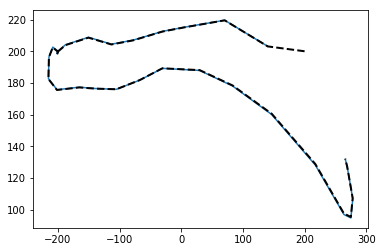

In [65]:
np.random.seed(123)
target_pos = [200, 200]

std_noise = math.radians(0.5)
dt = 0.5
Q=1.0
f = moving_target_filter(target_pos, std_noise, Q , dt)
xs, txs = plot_straight_line_target(f, std_noise, target_pos[0], target_pos[1])

In [66]:
df_kalman = pd.DataFrame(xs)
df_kalman.columns = ['x', 'vel_x', 'y', 'vel_y']

In [68]:
df_kalman.head()

,x,vel_x,y,vel_y
0,140.354023,1.192758,203.072452,0.063246
1,70.432590,1.398650,219.571984,0.331286
2,3.470409,1.339670,215.064396,0.088996
3,-30.247111,0.674603,212.559787,0.049304
4,-77.857636,0.952568,207.045298,0.109547


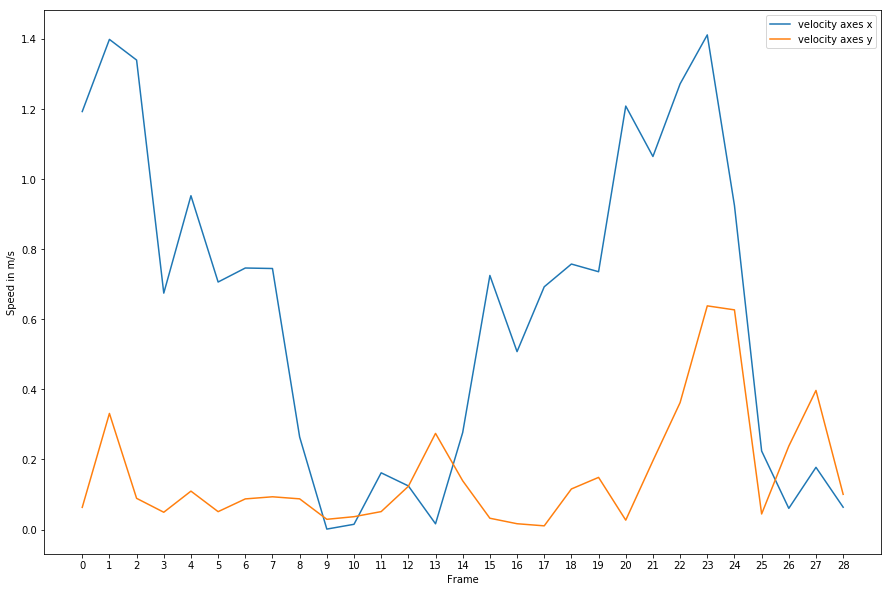

In [78]:
f = plt.figure(figsize=[15,10])
f = plt.plot(range(len(df_kalman)), df_kalman['vel_x'], label = 'velocity axes x')
f = plt.plot(range(len(df_kalman)), df_kalman['vel_y'], label = 'velocity axes y')
f = plt.legend(loc='upper right')
f = plt.xlabel('Frame')
f = plt.ylabel('Speed in m/s')
f = plt.xticks(range(len(df_kalman)))

### Calculate tot velocity 

In [93]:
from math import sqrt
initial_position_target = target_pos
dt = 0.5
velocity = []
for row in range(len(df_kalman)):
    x = df_kalman['x'][row]
    y = df_kalman['y'][row]
    if row ==0:
        previous_x = initial_position_target[0]
        previous_y = initial_position_target[1]
    else:
        previous_x = df_kalman['x'][row -1]
        previous_y = df_kalman['y'][row -1]
    distance = sqrt((x - previous_x)**2 + (y - previous_y)**2)
    velocity.append(distance/100/dt)
    
df_kalman['velocity'] = velocity
df_kalman.head()

,x,vel_x,y,vel_y,velocity
0,140.354023,1.192758,203.072452,0.063246,1.194501
1,70.432590,1.398650,219.571984,0.331286,1.436836
2,3.470409,1.339670,215.064396,0.088996,1.342274
3,-30.247111,0.674603,212.559787,0.049304,0.676208
4,-77.857636,0.952568,207.045298,0.109547,0.958576


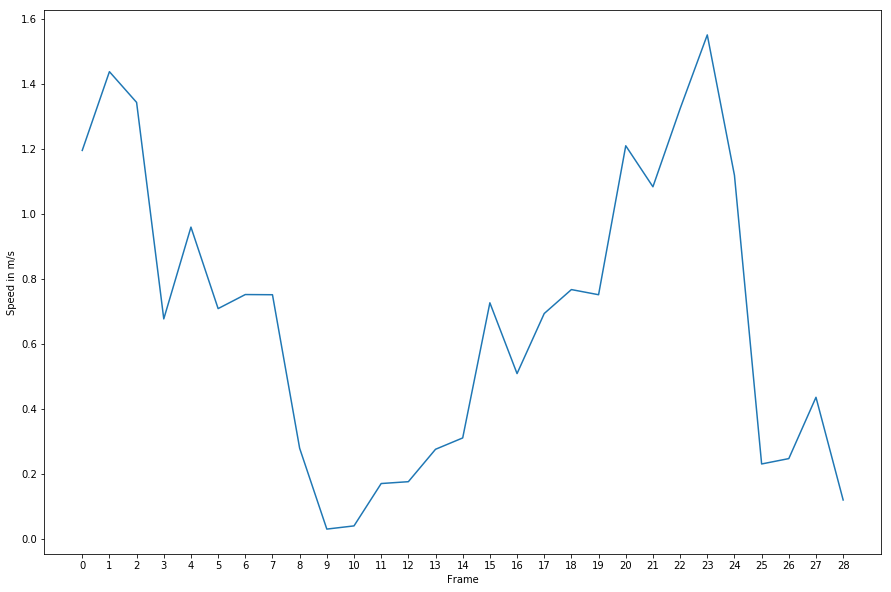

In [94]:
f = plt.figure(figsize=[15,10])
f = plt.plot(range(len(df_kalman)), df_kalman['velocity'])
f = plt.xlabel('Frame')
f = plt.ylabel('Speed in m/s')
f = plt.xticks(range(len(df_kalman)))